In [1]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import cv2

import requests
from io import BytesIO
from PIL import Image
import numpy as np

from moviepy.editor import VideoFileClip

# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20, 12

from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.structures.keypoint import keypoints_to_heat_map
from maskrcnn_benchmark.modeling.roi_heads.keypoint_head.loss import project_keypoints_to_heatmap
from predictor import COCODemo

In [2]:
config_file = "/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml"

cfg.merge_from_file("/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml")
cfg.merge_from_list(['DATALOADER.NUM_WORKERS', '2', \
                     'DATATYPE', 'bee', \
                     'OUTPUT_DIR', 'training_dir_v2/fcos_kps_ms_training_R_50_FPN_1x_bee1', \
                     'MODEL.WEIGHT', '/home/bsb2144/directpose/tools/training_dir_v2/fcos_kps_ms_training_R_50_FPN_1x_bee/model_final.pth',\
                     'DATASETS.TEST', "('bee_val_cocostyle',)",\
                     'DATASETS.TRAIN', "('bee_train_cocostyle', )",\
                    ])



In [3]:
coco_demo = COCODemo(
    cfg,
    min_image_size=800,
    confidence_threshold=0.2,
)


In [4]:
def load(img_path):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    
    pil_image = Image.open(img_path).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def load_video(video_path,frame_id=[0]):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    
    video_clip = VideoFileClip(video_path)
    if frame_id is None:
        nframes = int(video_clip.fps * video_clip.duration)
        frame_id = range(nframes)
    images = []
    for i in frame_id:
        image = video_clip.get_frame(i/video_clip.fps)
        # convert to BGR format
        image = np.array(image)[:, :, [2, 1, 0]]
        images += [image]
    video_clip.close()
    
    return images

def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")

In [5]:
#keypoints_to_heat_map(1,1,1)

In [6]:
#test_file = 'bee_test.mp4'
#frame_index = None
#images = load_video(test_file,frame_index)

#save_file = 'bee_test_pred.mp4'
#fourcc = cv2.VideoWriter_fourcc(*'XVID')
#dd1,dd2 = images[0].shape[0],images[0].shape[1]
#out = cv2.VideoWriter(save_file, fourcc, 20.0, (dd2,dd1))
#for image in images:
    # compute predictions
 #   predictions = coco_demo.run_on_opencv_image(image)

  #  out.write(predictions[:, :, [2, 1, 0]].astype(np.uint8))
#out.release()



In [7]:
#BUILDING OWN VISUALIZER

#1. obtain heatmap
#2. use function to get peaks
#3. Overlay peaks onto image
#4. voila

In [8]:
#test_file = 'bee_test.mp4'
#frame_index = None
#images = load_video(test_file,frame_index)

#save_file = 'bee_test_pred.mp4'
#fourcc = cv2.VideoWriter_fourcc(*'XVID')
#dd1,dd2 = images[0].shape[0],images[0].shape[1]
#out = cv2.VideoWriter(save_file, fourcc, 20.0, (dd2,dd1))
# compute predictions
#predictions, tp, hm_res, stride, hms = coco_demo.run_on_opencv_image(images[0])
#print(predictions)

#    out.write(predictions[:, :, [2, 1, 0]].astype(np.uint8))
#out.release()


In [9]:
#print(hms)

In [10]:
#print(tp.get_field('keypoints'))

In [11]:
#kps = tp.get_field('keypoints')
#ds = cfg.MODEL.ROI_MASK_HEAD.RESOLUTION

In [12]:
#(keypoints, rois, heatmap_size)
#keypoints_to_heat_map(kps,,1)

In [13]:
#hms, valid = project_keypoints_to_heatmap(kps, tp, ds)

In [14]:
# num keypoints per animal, heatmap
def calculate_peaks(numparts, heatmap_avg):
    score = np.ones((numparts,)) * 0.000001
    all_peaks = []
    peak_counter = 0
    if len(score) < numparts:
        score = score[:numparts]
        ##logger.ERROR(‘Not enough scores provided for number of parts’)
        # return
    # threshold_detection = params[‘thre1’]
    # tic_localmax=time.time()
    for part in range(numparts):
        map_ori = heatmap_avg[:, :, part]
        map = map_ori
        map_left = np.zeros(map.shape)
        map_left[1:, :] = map[:-1, :]
        map_right = np.zeros(map.shape)
        map_right[:-1, :] = map[1:, :]
        map_up = np.zeros(map.shape)
        map_up[:, 1:] = map[:, :-1]
        map_down = np.zeros(map.shape)
        map_down[:, :-1] = map[:, 1:]
        peaks_binary = np.logical_and(np.logical_and(np.logical_and(map >= map_left, map >= map_right),
                                                     np.logical_and(map >= map_up, map >= map_down)), map > score[part])
        peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]))  # note reverse
        peaks_with_score_and_id = [x + (map_ori[x[1], x[0]], i + peak_counter,) for i, x in
                                   enumerate(peaks)]  # if x[0]>0 and x[1]>0 ]
        all_peaks.append(peaks_with_score_and_id)
        peak_counter += len(peaks)
    return all_peaks



In [24]:
#test_file = 'bee_test.mp4'
#frame_index = None
#images = load_video(test_file,frame_index)
#image = images[10]
#ogimg = images[10]
test_file = 'train_ex.jpg'
frame_index = None
image = load(test_file)
#image = images[10]
ogimg = image
# imshow(image)
# compute predictions
predictions, tps, hm_res, stride, hms, targets = coco_demo.run_on_opencv_image(image)
np.shape(hms)
hms_tensor = hms.cpu().data.numpy()   
peaks = calculate_peaks(5, hms_tensor)    
    


coords
tensor([[  0,   0,  16, 109],
        [  0,   0,  19,  89],
        [  0,   0,  21, 148],
        [  0,   0,  51,  46],
        [  0,   0,  52, 155],
        [  0,   0,  56,  94],
        [  0,   0,  57, 121],
        [  0,   0,  72,  99],
        [  0,   0,  72, 122],
        [  0,   0,  74, 152],
        [  0,   1,   7, 144],
        [  0,   1,  12,  91],
        [  0,   1,  37,  98],
        [  0,   1,  57, 112],
        [  0,   1,  59, 146],
        [  0,   1,  61,  32],
        [  0,   1,  67, 136],
        [  0,   1,  67, 154],
        [  0,   1,  79, 140],
        [  0,   1,  83, 113],
        [  0,   2,  13, 145],
        [  0,   2,  14,  99],
        [  0,   2,  29,  93],
        [  0,   2,  57, 105],
        [  0,   2,  58,  38],
        [  0,   2,  60, 154],
        [  0,   2,  63, 130],
        [  0,   2,  67, 146],
        [  0,   2,  77, 133],
        [  0,   2,  78, 105],
        [  0,   3,   0,  97],
        [  0,   3,   5, 146],
        [  0,   3,  10,  92],
   

In [25]:
print(np.shape(predictions))
print(np.shape(targets))

(1440, 2560, 3)
()


In [26]:
filename = 'bee_dp_labeled.jpg'
cv2.imwrite(filename, predictions[:, :, [2, 1, 0]]) 

True

In [27]:
from maskrcnn_benchmark.utils import cv2_util
import matplotlib.pyplot as plt
#cv2.applyColorMap(np.float32(hms_tensor[0][0]), cv2.COLORMAP_JET)

In [28]:
import numpy as np
import math

def sigmoid(x):
  return 1 / (1 + math.exp(-x))
# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)

# test
print(sigmoid_v(hms_tensor[0][0]))

[[0.01178878 0.00302758 0.00274516 ... 0.00246533 0.00402918 0.01447962]
 [0.00348106 0.0009513  0.00074898 ... 0.0005717  0.00090897 0.00476811]
 [0.00390784 0.00083937 0.00057427 ... 0.00056724 0.00088499 0.00441143]
 ...
 [0.00426054 0.00151898 0.00122868 ... 0.00043474 0.00084818 0.00383845]
 [0.00314219 0.00099903 0.000994   ... 0.00050129 0.00098061 0.00461954]
 [0.01084804 0.00353212 0.0039076  ... 0.00304936 0.00482448 0.0147791 ]]


In [29]:
# First keypoint (tail)
#sigmoid_v
#arr1 = (hms_tensor[0][0]).astype(np.uint8)
#arr1 = cv2.applyColorMap(arr1, cv2.COLORMAP_MAGMA)
#imgplotog1 = plt.imshow(ogimg)
#plt.show()
#imgplot1 = plt.imshow(arr1)
#plt.show()


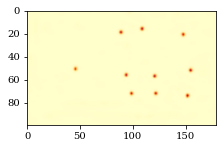

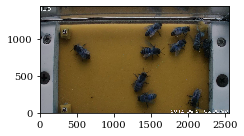

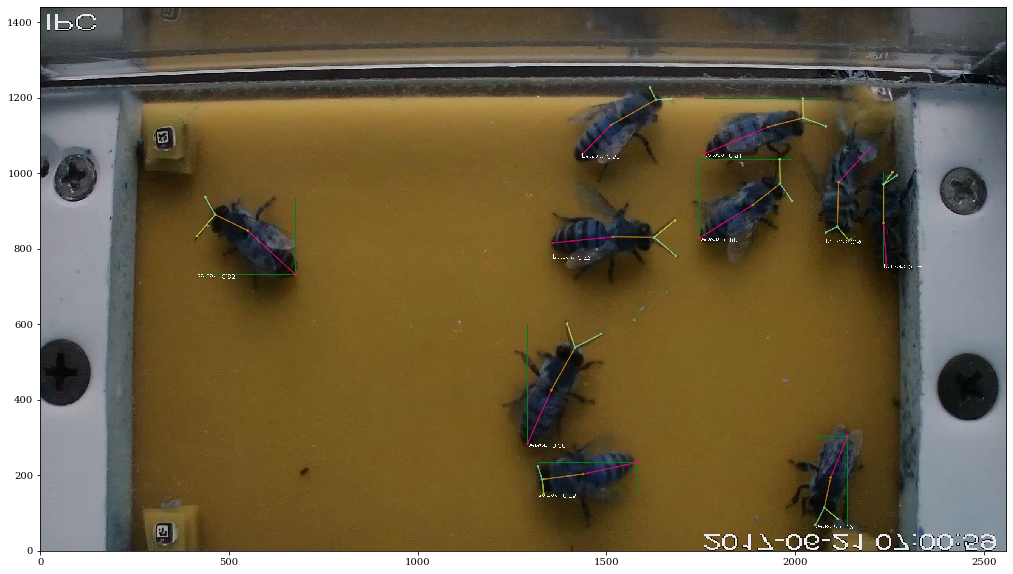

In [36]:
#tail keypoint
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
fig, ax = plt.subplots()
data = gaussian_filter(sigmoid_v(hms_tensor[0][0]), sigma=1)
ax = plt.gca()
ax.invert_yaxis()
plt.pcolormesh(data, cmap='YlOrRd', shading='gouraud')
plt.savefig('bee_100_std_hm.png')
fig.canvas.draw()
plt.pause(5)
#arr1 = (data).astype(np.uint8)
#arr1 = cv2.applyColorMap(arr1, cv2.COLORMAP_MAGMA)
imgplotog1 = plt.imshow(ogimg)
#plt.show()
#imgplot1 = plt.imshow(arr1)
plt.show()
plt.pause(5)
plt.figure(figsize=(20,10))
img = predictions[:, :, [2, 1, 0]]
b,g,r = cv2.split(img)       # get b,g,r
img = cv2.merge([r,g,b])     # switch it to rgb
imp = plt.imshow(img)
plt.show()
plt.pause(5)
#print(data)

In [34]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import matplotlib.colorbar as colorbar
num_plots = 3
# sample data
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'jet',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 10, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    'font.size': 12, # was 10
    'legend.fontsize': 10, # was 10
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    #'text.usetex': True,
    'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

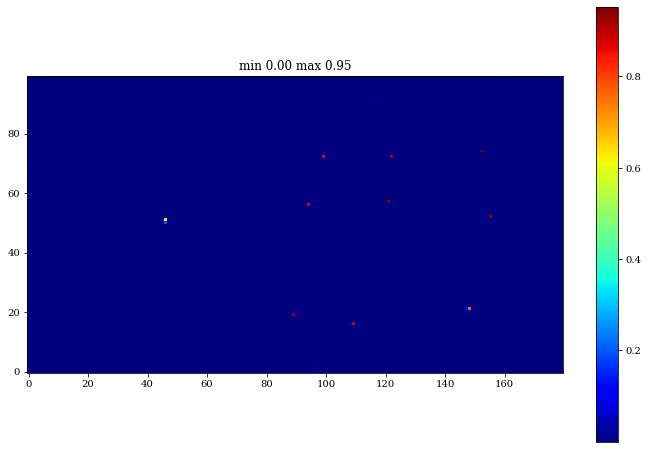

In [56]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
data_temp = gaussian_filter(sigmoid_v(hms_tensor[0][0]), sigma=.3)
ax.set_title('min {:.2f} max {:.2f}'.format(data_temp.min(), data_temp.max()))
im = ax.imshow(sigmoid_v(hms_tensor[0][0]), interpolation='none', vmin= data_temp.min(), vmax=data_temp.max())
cbar = fig.colorbar(im, ax=ax)
plt.show()


In [55]:
print(sigmoid_v(hms_tensor[0][0]).max())
print(gaussian_filter(sigmoid_v(hms_tensor[0][0]), sigma=.3).max())

0.9670834160178823
0.9523765999551989


In [ ]:
# Second keypoint (head)
arr2 = hms_tensor[0][1].astype(np.uint8)
arr2 = cv2.applyColorMap(arr2, cv2.COLORMAP_JET)
imgplotog2 = plt.imshow(ogimg)
plt.show()
imgplot2 = plt.imshow(arr2)
plt.show()

In [ ]:
# Third keypoint (thorax)
arr3 = hms_tensor[0][2].astype(np.uint8)
arr1 = cv2.applyColorMap(arr8, cv2.COLORMAP_JET)
imgplotog1 = plt.imshow(ogimg)
plt.show()
imgplot1 = plt.imshow(arr1)
plt.show()

In [ ]:
# First keypoint (right antena)
arr1 = hms_tensor[0][0].astype(np.uint8)
arr1 = cv2.applyColorMap(arr8, cv2.COLORMAP_JET)
imgplotog1 = plt.imshow(ogimg)
plt.show()
imgplot1 = plt.imshow(arr1)
plt.show()

In [ ]:
# Fifth keypoint (left antena)
arr1 = hms_tensor[0][0].astype(np.uint8)
arr1 = cv2.applyColorMap(arr8, cv2.COLORMAP_JET)
imgplotog1 = plt.imshow(ogimg)
plt.show()
imgplot1 = plt.imshow(arr1)
plt.show()

In [ ]:
filename = 'AAA_B1'+'.jpg'
cv2.imwrite(filename, predictions[:, :, [2, 1, 0]]) 

In [ ]:
np.shape(peaks[4])

In [ ]:
import torch
masks_per_dim = 5
result = torch.zeros(
            (masks_per_dim * 800, masks_per_dim * 1422), dtype=torch.uint8)

In [ ]:
np.shape(result.numpy())

In [ ]:
print(stride)